# Student: Tristan Bouchard, 260747124

## 2.2 Epipolar Geometry (27 points)


In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import skimage

import sys
import re
from struct import *
import numpy as np
from matplotlib import pyplot as plt

def read_pfm(file):
    # Adopted from https://stackoverflow.com/questions/37073108/how-to-read-pfm-files-provided-with-middlebury-dataset?rq=1
    with open(file, "rb") as f:
        # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
        type = f.readline().decode('latin-1')
        if "PF" in type:
            channels = 3
        elif "Pf" in type:
            channels = 1
        else:
            sys.exit(1)
        # Line 2: width height
        line = f.readline().decode('latin-1')
        width, height = re.findall('\d+', line)
        width = int(width)
        height = int(height)

        # Line 3: +ve number means big endian, negative means little endian
        line = f.readline().decode('latin-1')
        BigEndian = True
        if "-" in line:
            BigEndian = False
        # Slurp all binary data
        samples = width * height * channels;
        buffer = f.read(samples * 4)
        # Unpack floats with appropriate endianness
        if BigEndian:
            fmt = ">"
        else:
            fmt = "<"
        fmt = fmt + str(samples) + "f"
        img = unpack(fmt, buffer)
        img = np.flipud(np.array(img).reshape(height, width))
    return img

""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    r, c = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 5)
        img1 = cv2.circle(img1, tuple(pt1), 10, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 10, color, -1)
    return img1, img2

### 2.2.1 Compute matching SIFT keypoints from a stereo image pair. (5 points)

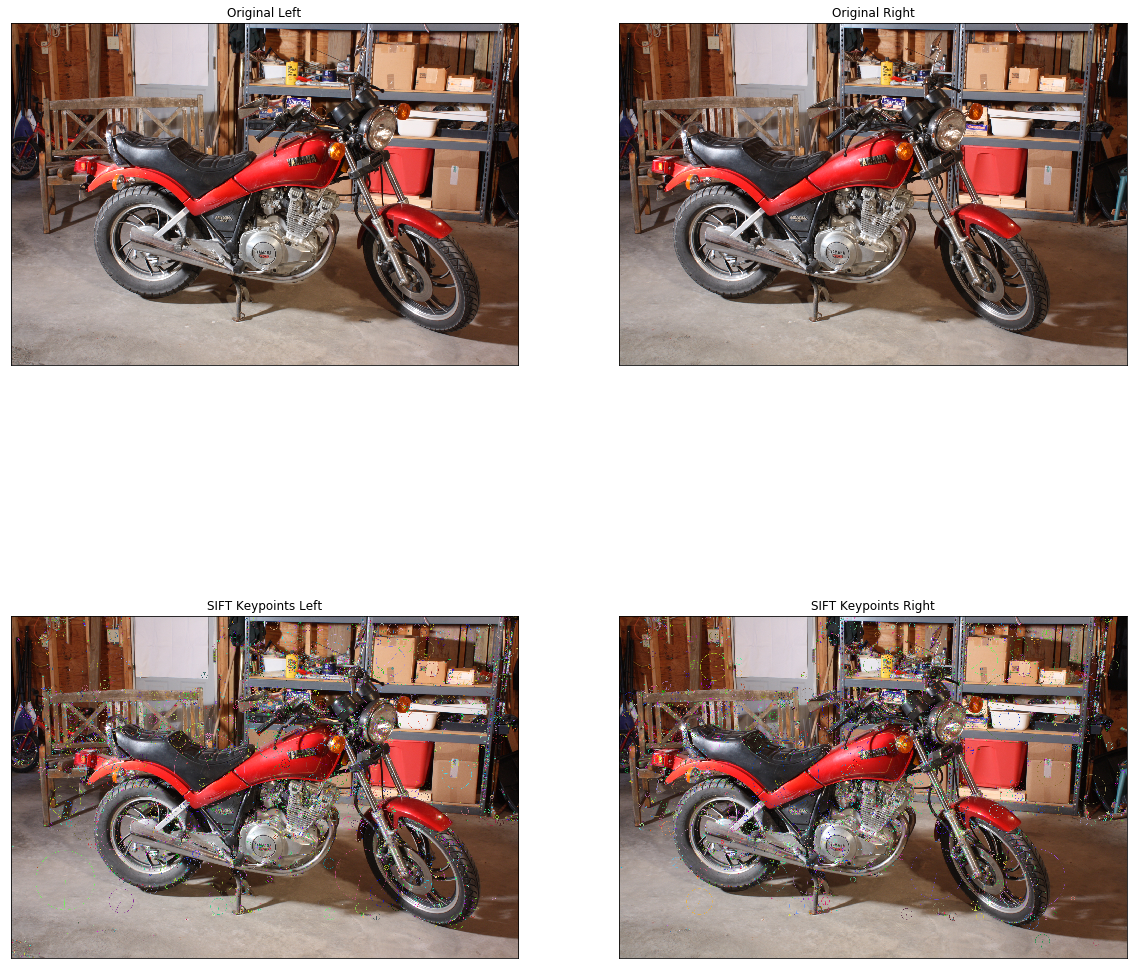

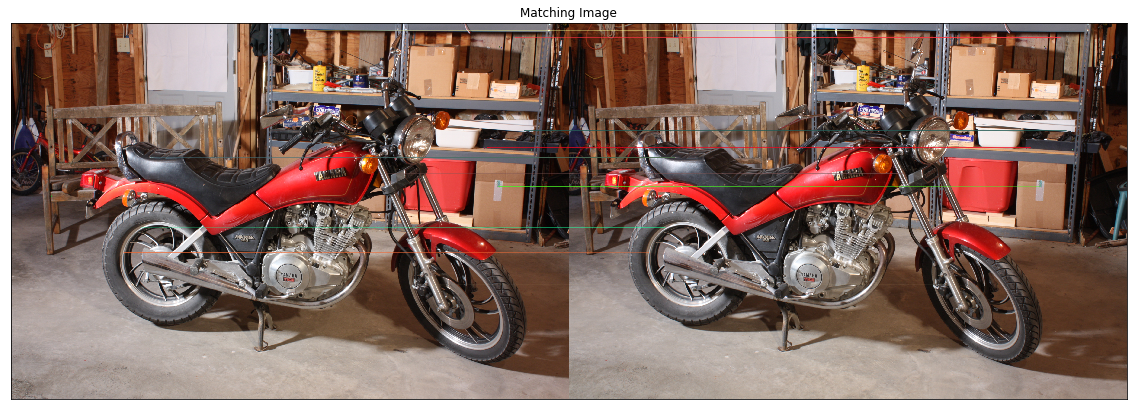

In [2]:
imgL = cv2.imread('im0.png')
imgR = cv2.imread('im1.png')

imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

# imgL_scaled = cv2.resize(imgL, (0,0), fx=0.3, fy=0.3)
# imgR_scaled = cv2.resize(imgR, (0,0), fx=0.3, fy=0.3)
imgL_scaled = imgL.copy()
imgR_scaled = imgR.copy()

# Compute SIFT Keypoints in each image
sift = cv2.xfeatures2d.SIFT_create()

# Calculate keypoints and descriptors
kptsL, descL = sift.detectAndCompute(imgL_scaled, None)
kptsR, descR = sift.detectAndCompute(imgR_scaled, None)

# Draw sift features to images
imgL_disp = imgL_scaled.copy()
imgL_disp2 = imgL_scaled.copy()
imgR_disp = imgR_scaled.copy()
imgR_disp2 = imgR_scaled.copy()


cv2.drawKeypoints(imgL_disp, kptsL, imgL_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(imgR_disp, kptsR, imgR_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# create BFMatcher object
bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(descL,descR)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 20 matches.
matchingImage = cv2.drawMatches(imgL_disp2,kptsL,imgR_disp2,kptsR, matches[:20], imgL_scaled, flags=2)

# Draw images
images = [imgL, imgR , imgL_disp, imgR_disp, matchingImage]
titles = ["Original Left","Original Right","SIFT Keypoints Left", "SIFT Keypoints Right", "Matching Image"]

plt.figure(figsize=(20,20))
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

plt.figure(figsize=(20,20))
plt.imshow(images[4])
plt.title(titles[4])
plt.xticks([]),plt.yticks([])
plt.show()

### 2.2.2 Compute and display the epipolar lines for both images. (5 points)

(Much of the code in this section was taken from the tutorial 6 notebook)

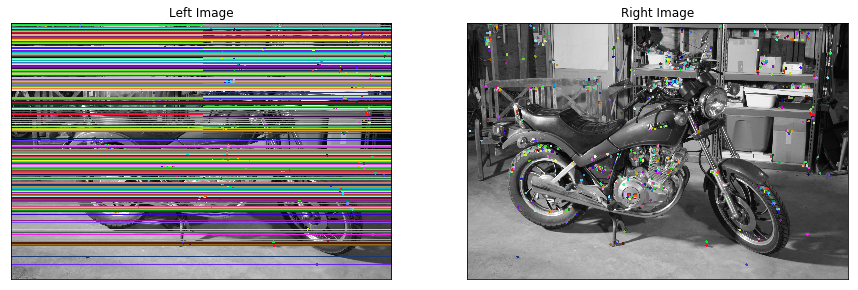

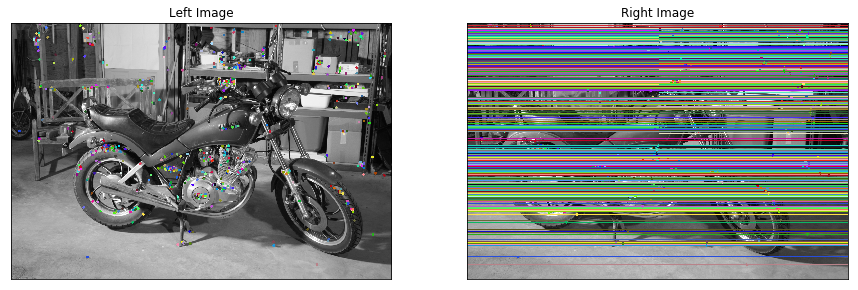

In [3]:
# Convert input images to greyscale
imgL_grey = cv2.cvtColor(imgL_scaled, cv2.COLOR_RGB2GRAY)
imgR_grey = cv2.cvtColor(imgR_scaled, cv2.COLOR_RGB2GRAY)

# match descriptors (find the best two matches for each descriptor)
matches2 = bf.knnMatch(descL, descR, k=2)

# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches2):
    if m.distance < 0.25 * n.distance:
        good.append(m)
        ptsR.append(kptsR[m.trainIdx].pt)
        ptsL.append(kptsL[m.queryIdx].pt)

# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)
                    
# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)
# draw lines
imgL1, imgR1 = drawlines(imgL_grey, imgR_grey, linesL, ptsL, ptsR)

linesR = cv2.computeCorrespondEpilines(ptsL, 2, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2 = drawlines(imgR_grey, imgL_grey, linesR, ptsR, ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

### 2.2.3 Pick any one keypoint in the right image which doesn't have a correct match in the left image, and is not on the corresponding epipolar line. Extract a patch of size (5 x 5) around this keypoint in the right image. (2 points)

[1534, 1400]
[2208, 1340]


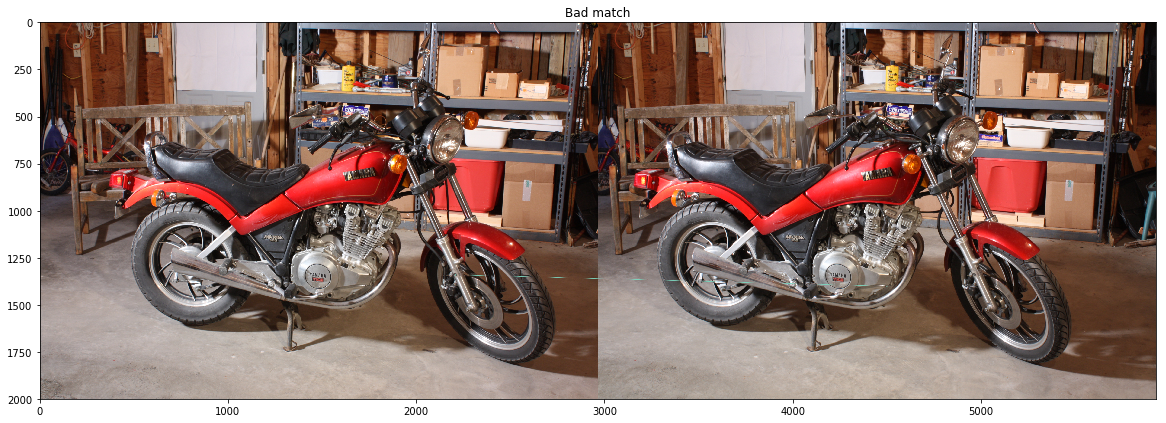

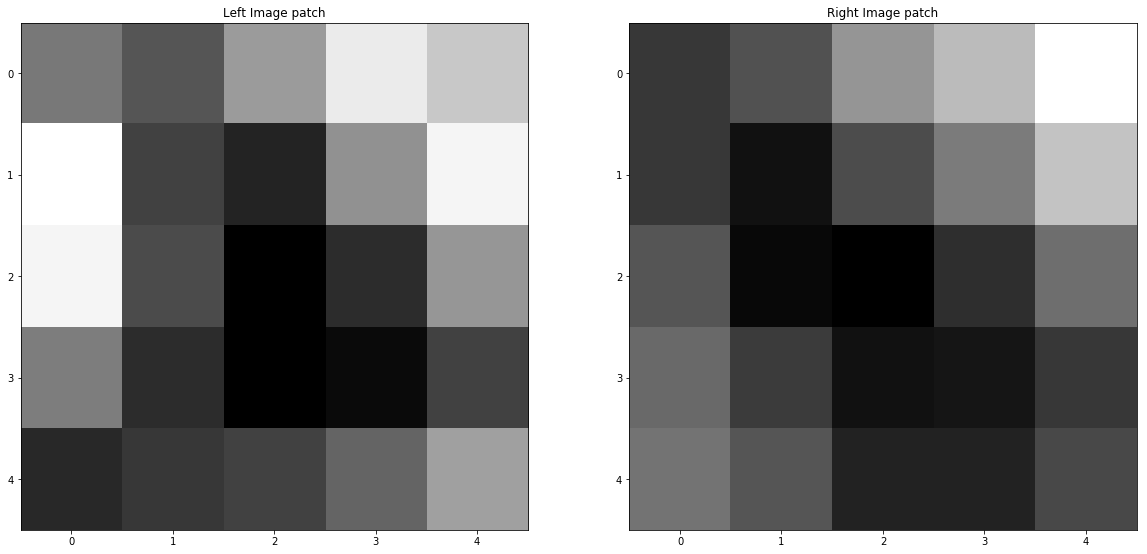

In [4]:
# Pick the worst match in the list of ordered matches
matchingImage2 = cv2.drawMatches(imgL_disp2,kptsL,imgR_disp2,kptsR, matches[len(matches)-1 : ], imgL_scaled, flags=2)
#matchingImage3 = cv2.drawMatches(imgL_disp2,kptsL,imgR_disp2,kptsR, matches[:1], imgL_scaled, flags=2)
m = matches[len(matches)-1]

#test = kptsL[m.trainIdx].pt
y_x_right = [int(kptsR[m.trainIdx].pt[0]),int(kptsR[m.trainIdx].pt[1])]
y_x_leftq = [int(kptsL[m.queryIdx].pt[0]),int(kptsL[m.queryIdx].pt[1])]

print(y_x_right)
print(y_x_leftq)
imgR_Gray = cv2.cvtColor(imgR,cv2.COLOR_RGB2GRAY)
imgL_Gray = cv2.cvtColor(imgL,cv2.COLOR_RGB2GRAY)
patch_center_left = np.asarray(y_x_leftq)
patch_center_right = np.asarray(y_x_right)
patch_size = 5
patch_x_left = patch_center_left[1] - int(patch_size/2)
patch_y_left = patch_center_left[0] - int(patch_size/2)
patch_image_left = imgL_Gray[patch_x_left:patch_x_left+patch_size, patch_y_left:patch_y_left+patch_size]

patch_x_right = patch_center_right[1] - int(patch_size/2)
patch_y_right = patch_center_right[0] - int(patch_size/2)
patch_image_right = imgR_Gray[patch_x_right:patch_x_right+patch_size, patch_y_right:patch_y_right+patch_size]

# plt.figure(figsize=(20,20))
# plt.imshow(matchingImage3)
# plt.show()
plt.figure(figsize=(20,20))
plt.imshow(matchingImage2)
plt.title("Bad match")
#plt.xticks([]),plt.yticks([])
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(1,2,1),plt.imshow(patch_image_left,cmap='gray')
plt.title("Left Image patch")
#plt.xticks([]),plt.yticks([])
plt.subplot(1,2,2),plt.imshow(patch_image_right,cmap='gray')
plt.title("Right Image patch")
#plt.xticks([]),plt.yticks([])
plt.show()


#### 2.2.4 Match the extracted patch using the sum of squared difference (SSD) with every patch along the corresponding epipolar line in the left image. (7 points)

So, I'm having a lot of trouble finding how this point can reside on an epiline (if it even does) so I'm going to pick a point at random, as explained in the discussion board thread "Confused about wording for Q2.2"

In [5]:
""" drawlines, modified to print out X,Y coords of a point on the epiline"""

def drawlines2(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    r, c = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        print(pt2)  # print kpts
        
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 5)
        img1 = cv2.circle(img1, tuple(pt1), 15, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 15, color, -1)
    return img1, img2

[995 435]
[ 890 1229]
[1004  450]
[1011  456]
[ 908 1191]
[1018  458]
[1018  480]
[1026  626]
[1035  552]
[1037  633]
[ 954 1138]
[1109  604]
[ 972 1071]
[ 980 1131]
[1137  209]
[1137  209]
[1138  270]
[1000 1115]
[1143  198]
[ 997 1046]
[1004 1134]
[1007 1146]
[1157  149]
[1016 1133]
[1020 1129]


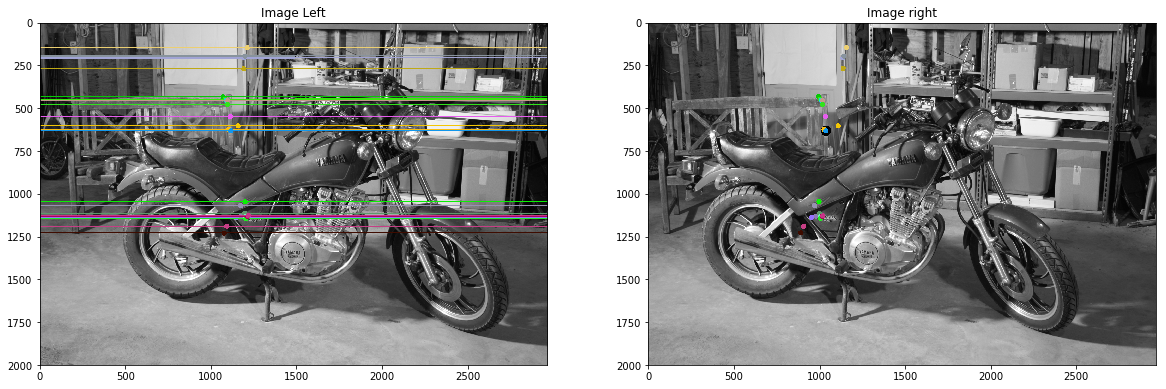

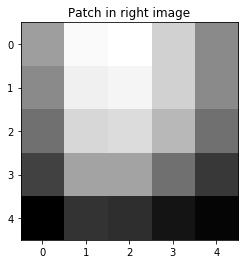

In [6]:
# Attempt to find on which epiline my keypoint is in the right image

newlinesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
newlinesL = newlinesL.reshape(-1, 3)

imgL_draw = imgL_Gray.copy()
imgR_draw = imgR_Gray.copy()

imgR_draw = cv2.circle(imgR_draw, tuple([1037, 633]), 30,tuple([0, 0, 0]), -1)

imgL_bad, imgR_bad = drawlines2(imgL_draw, imgR_draw, newlinesL[150:175], ptsL[150:175], ptsR[150:175])

patch_point = np.asarray([1037,633])
patch2 = imgL_Gray[patch_point[0]-2:patch_point[0]+3,patch_point[1]-2:patch_point[1]+3]

plt.figure(figsize=(20,20))
plt.subplot(1,2,1),plt.imshow(imgL_bad)
plt.title("Image Left")
plt.subplot(1,2,2),plt.imshow(imgR_bad)
plt.title("Image right")
plt.show()

#plt.figure(figsize=(20,20))
plt.imshow(patch2, cmap='gray')
plt.title("Patch in right image")
plt.show()

# pt is [1037 ,633] in right image which falls just under its epiline visually

#### 2.2.5 Plot SSD values (refer Lecture 14 slide 5). Find the matching point with minimum SSD value. Display found matching points in both the images. (4 points)

[1037  633]


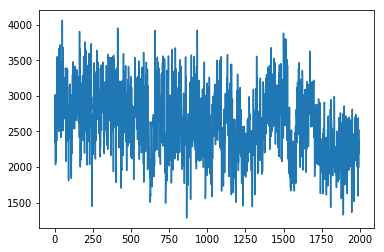

In [7]:
# Used to contain SSD values when moving patch
ssd = []



# point on img right is index 159 in points
print(ptsR[159])
# Line on which this point lays on is epiline # 159
epiline = newlinesL[159]

# Need to figure out slope and intercepts of line (code from tutorial)
x0, y0 = map(int, [0, -epiline[2]/epiline[1]])
x1, y1 = map(int, [imgR.shape[1], -(epiline[2]+epiline[0]*imgR.shape[1])/epiline[1]])

# y = mx + b
m = (y1-y0)/(x1-x0)
b = y1-m*x1

# Move pixel patch and compute SSD at each spot
row_size = imgL.shape[0]
for i in range(2, row_size- 2):
    center_point_y = int(m*i+b)
    x_y = (i, center_point_y)
    new_patch = imgL_Gray[x_y[0] - 2 : x_y[0] + 3, x_y[1] - 2 : x_y[1] + 3] 
    ssd_computed = np.sum((patch2 - new_patch)**2)
    ssd.append((ssd_computed))
    

plt.plot(ssd)
plt.show()

(865, 633)


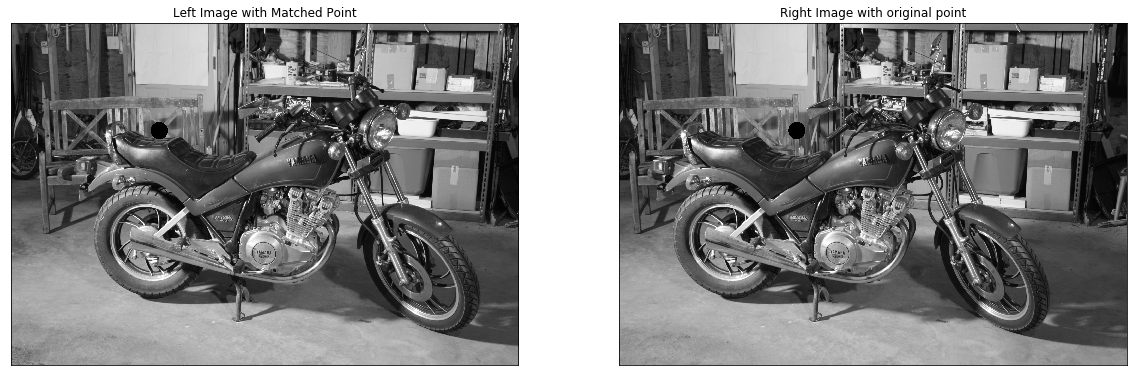

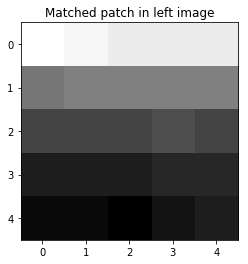

In [8]:
# Compute matching point from the SSD
imgL_Final = imgL_Gray.copy()
imgR_Final = imgR_Gray.copy()

match_point = (np.argmin(ssd), patch_point[1])
print(match_point)

matched_patch = imgL_Gray[865 - 2 : 865 + 3, 633 - 2 : 633 + 3]

imgL_final_draw = cv2.circle(imgL_Final, (match_point[0],match_point[1]), 50,tuple([0, 0, 0]), -1)
imgR_final_draw = cv2.circle(imgR_Final, (patch_point[0],patch_point[1]), 50,tuple([0, 0, 0]), -1)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1), plt.imshow(imgL_final_draw, cmap="gray")
plt.title("Left Image with Matched Point"), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(imgR_final_draw, cmap="gray")
plt.title("Right Image with original point"), plt.xticks([]), plt.yticks([])
plt.show()

plt.imshow(matched_patch, cmap='gray')
plt.title("Matched patch in left image")
plt.show()


#### 2.2.6 Did you find exactly one matching point with lowest SSD or multiple? Is the found matching point correct one? Explain why. (2 points)

Looking at the SSD plot, it is quite obvious that there could be a few matches which minimize the SSD. However, the point that I chose on my epipolar line does not minimize the SSD very well as it moves along the epiline, such that all the points that seem to match are still very far from matching. However, the point at which it the SSD SHOULD be minimized, i.e. x = 1037 seems to have some sort of a minimum, which means that there is some sort of match detected there. Thus, the matching point found is not the correct one, as can be seen in the images above.

### 2.2.7 Suppose you found multiple matches in the previous question. What constraint(s) could be imposed on the matching algorithm to find a single match? (1 point)

A constraint that could be added to the alorithm is to scale the patch size upwards while blurring the image, such that there is better large scale understanding of the image. This may lead to a better single match.

### 2.2.8 Suppose you found exactly one match with the lowest SSD, but it is incorrect one. What constraint(s) could be imposed to find a correct match? (1 point)

As before, a good idea would be to scale up the patch we are searching with in size while progressively blurring the image such that the algorithm can get a better large scale understanding of the scene. This would allow the patch to be more precisely placed on the image.